멀티 에이전트 시스템 & RouteLLM
- Router에 쿼리가 들어오면 Conditional Edge로, 에이전트 1 || 에이전트 2에 연결
- 대부분의 사내 서비스들은 구체적인 목적이 존재 
- 특정 목적을 지닌 질문 외에, 일반적인 질문 또한 에이전트 3에서 처리 (e.g. Adaptive RAG)

<img src="/Users/seonghoe/인프런_랭그래프/lecture./langgraph/멀티에이전트_도식화.png">

환경변수 설정

In [28]:
from dotenv import load_dotenv

load_dotenv()

True

LLM 선언 (Claude, OpenAI, Azure, Gemini)

In [29]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

small_llm = ChatOpenAI(model='gpt-4o-mini')


STATE 정의

In [30]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list
    answer: str

graph_builder = StateGraph(AgentState)

라우터 정의

In [31]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Literal

class Route(BaseModel): # 출력 스키마 정의
    target: Literal['income_tax', 'llm', 'real_estate'] = Field(
        description="The target for the query to answer"
    )

router_system_prompt = """
You are an expert at routing a user's question to 'income_tax', 'llm', or 'real_estate'
'income_tax' contaions information about income tax up to December 2024.
'real_estate' contaions information about income tax up to December 2024.
if you think the question isn't related to either 'income_tax', or 'real_estate';
tou can route it to 'llm'.
"""

router_prompt = ChatPromptTemplate.from_messages([
    ('system', router_system_prompt),
    ('user', '{query}')
])

structured_router_llm = small_llm.with_structured_output(Route)    # LLM 출력 스키마 강제

def router(state: AgentState):
    query = state['query']
    router_chain = router_prompt | structured_router_llm 
    route = router_chain.invoke({'query': query})
    print(f'router route == {route}')
    print(f'route.target == {route.target}')
    return route.target

In [32]:
from langchain_core.output_parsers import StrOutputParser

def call_llm(state: AgentState):
    query = state['query']
    llm_chain = small_llm | StrOutputParser()
    llm_answer = llm_chain.invoke(query)    # 프롬프트 템플릿(ChatPromptTemplate)이 있으면 dict, 없으면 value(str)

    return {'answer': llm_answer} 

노드 추가

In [33]:
from tax import graph as income_tax_agent
from estate import graph as real_estate_agent

# Router는 doc_check_relevance와 같이, 조건부로 뿌려주는 역할이라 노드로 추가 안함
graph_builder.add_node('income_tax', income_tax_agent)
graph_builder.add_node('real_estate', real_estate_agent)
graph_builder.add_node('llm', call_llm)

엣징

In [35]:
from langgraph.graph import START, END

graph_builder.add_conditional_edges(
    START,
    router,
    {
        'income_tax': 'income_tax',
        'real_estate': 'real_estate',
        'llm': 'llm'
    }
)
graph_builder.add_edge('income_tax', END)
graph_builder.add_edge('real_estate', END)
graph_builder.add_edge('llm', END)

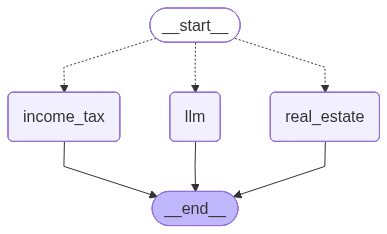

In [36]:
from IPython.display import Image, display

graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [37]:
initial_state = {'query': '소득세란 무엇인가요?'}
graph.invoke(initial_state)

router route == target='income_tax'
route.target == income_tax
context == [Document(metadata={'source': './documents/income_tax.txt'}, page_content='①조 세특례제한법, 또는 이 법 제12조에 따른 과세제외 소득  \n대통령령으로 정하는 임금소득(이하 “임금소득”이라 한다)과 근로소득  \n\n제12조제2항의 세호에 따라 원천징수하는 이자소득 및 배당소득과 제16조제1항제10호에 따른 직장공제회초 관련소득  \n\n\n법인으로 보는 단체 외의 단체 중 소득을 구성함에 배분하지 아니하는 단체로서 단체를 표기하는 금융거래를 하는 단체가 “금융신용기관” 및 비임금소득에 관한 법령이 제20조제1항 목의 이후에 해당하는 금융사업을 하는 단체(이하 “금융회사”等이란)로부터 받은 이자소득 및 배당소득  \n\n\n①조 세특례제한법에 따른 보통계소득  \n\n\n제30조부터 제35조까지의 규정 외의 이자소득과 배당소득(제17조제1항제8호에 따른 배당소득을 제외한다)으로서 그 소득의 합계액이 2천만원(이하 “이자소득의 종합세액기준금액”이라 한다) 이하인 경우 제17조에 따른 원천징수된 소득  \n\n\n해당 과세기간에 배당행정을 정하는 총수입금액의 합계액이 2천만원 이하인 자의 주택임대소득(이하 “분리과세 주택임대소득”이라 한다). 이 경우 주택임대소득이 산정 등에 필요한 대책행령으로 정한다.  \n\n\n다음 각 목 외의 기타소득(이하 “분리과세 기타소득”이라 한다)  \n\n\n가. 제21조제1항제3호 제4항, 제19조, 제20조제1항, 제22조제2항, 제26조 및 제26조의2 및 제 127조에 따라 원천징수(제21조제19항에 의하여 원천징수되지 아니하는 경우를 포함한다) 소득. 다만, 해당 소득이 있는 거주자가 종합소득과세표준을 계산해 고소득을 합산하는 경우 그 소득은 분리과세로 세액계산에 제외한다.  \n나. 제21조제19항제2조 및 같은 조 제2항에 따

{'query': '소득세란 무엇인가요?',
 'context': [Document(metadata={'source': './documents/income_tax.txt'}, page_content='①조 세특례제한법, 또는 이 법 제12조에 따른 과세제외 소득  \n대통령령으로 정하는 임금소득(이하 “임금소득”이라 한다)과 근로소득  \n\n제12조제2항의 세호에 따라 원천징수하는 이자소득 및 배당소득과 제16조제1항제10호에 따른 직장공제회초 관련소득  \n\n\n법인으로 보는 단체 외의 단체 중 소득을 구성함에 배분하지 아니하는 단체로서 단체를 표기하는 금융거래를 하는 단체가 “금융신용기관” 및 비임금소득에 관한 법령이 제20조제1항 목의 이후에 해당하는 금융사업을 하는 단체(이하 “금융회사”等이란)로부터 받은 이자소득 및 배당소득  \n\n\n①조 세특례제한법에 따른 보통계소득  \n\n\n제30조부터 제35조까지의 규정 외의 이자소득과 배당소득(제17조제1항제8호에 따른 배당소득을 제외한다)으로서 그 소득의 합계액이 2천만원(이하 “이자소득의 종합세액기준금액”이라 한다) 이하인 경우 제17조에 따른 원천징수된 소득  \n\n\n해당 과세기간에 배당행정을 정하는 총수입금액의 합계액이 2천만원 이하인 자의 주택임대소득(이하 “분리과세 주택임대소득”이라 한다). 이 경우 주택임대소득이 산정 등에 필요한 대책행령으로 정한다.  \n\n\n다음 각 목 외의 기타소득(이하 “분리과세 기타소득”이라 한다)  \n\n\n가. 제21조제1항제3호 제4항, 제19조, 제20조제1항, 제22조제2항, 제26조 및 제26조의2 및 제 127조에 따라 원천징수(제21조제19항에 의하여 원천징수되지 아니하는 경우를 포함한다) 소득. 다만, 해당 소득이 있는 거주자가 종합소득과세표준을 계산해 고소득을 합산하는 경우 그 소득은 분리과세로 세액계산에 제외한다.  \n나. 제21조제19항제2조 및 같은 조 제2항에 따른 기타소득  \n다. 제21조제19항제20호에 따른 기타소득 중 

In [26]:
initial_state = {'query': '집 15억은 세금을 얼마나 내나요?'}
graph.invoke(initial_state)

router route == target='real_estate'
route.target == real_estate
tax_base == 과세표준을 계산하기 위해 주어진 정보를 사용하겠습니다.

1. 주택 공시가격의 합: 15억 원
2. 사용자가 1세대 1주택자인 경우 공제금액: 12억 원
3. 공정시장가액비율: 60%

과세표준 = (주택 공시가격의 합 - 공제액) × 공정시장가액비율

1세대 1주택자인 경우:
과세표준 = (15억 - 12억) × 0.6 = 3억 × 0.6 = 1억 8천만 원

따라서, 1세대 1주택자인 경우 과세표준은 1억 8천만 원입니다.

일반 납세자의 경우 공제금액: 9억 원

일반 납세자인 경우:
과세표준 = (15억 - 9억) × 0.6 = 6억 × 0.6 = 3억 6천만 원

따라서, 일반 납세자인 경우 과세표준은 3억 6천만 원입니다.
tax_rate == 주어진 정보를 바탕으로 종합부동산세를 계산하겠습니다.

1. **1세대 1주택자**인 경우:
   - 과세표준: 1억 8천만 원
   - 과세표준이 3억 원 이하이므로 세율은 1천분의 5입니다.
   - 세액 = 1억 8천만 원 × 0.005 = 90만 원

2. **일반 납세자**인 경우:
   - 과세표준: 3억 6천만 원
   - 과세표준이 3억 원 초과 6억 원 이하 구간에 해당합니다.
   - 세율은 150만 원 + (3억 원을 초과하는 금액의 1천분의 7)입니다.
   - 초과 금액 = 3억 6천만 원 - 3억 원 = 6천만 원
   - 추가 세액 = 6천만 원 × 0.007 = 42만 원
   - 총 세액 = 150만 원 + 42만 원 = 192만 원

따라서, 1세대 1주택자인 경우 종합부동산세는 90만 원이고, 일반 납세자인 경우 종합부동산세는 192만 원입니다.


{'query': '집 15억은 세금을 얼마나 내나요?',
 'answer': '주어진 정보를 바탕으로 종합부동산세를 계산하겠습니다.\n\n1. **1세대 1주택자**인 경우:\n   - 과세표준: 1억 8천만 원\n   - 과세표준이 3억 원 이하이므로 세율은 1천분의 5입니다.\n   - 세액 = 1억 8천만 원 × 0.005 = 90만 원\n\n2. **일반 납세자**인 경우:\n   - 과세표준: 3억 6천만 원\n   - 과세표준이 3억 원 초과 6억 원 이하 구간에 해당합니다.\n   - 세율은 150만 원 + (3억 원을 초과하는 금액의 1천분의 7)입니다.\n   - 초과 금액 = 3억 6천만 원 - 3억 원 = 6천만 원\n   - 추가 세액 = 6천만 원 × 0.007 = 42만 원\n   - 총 세액 = 150만 원 + 42만 원 = 192만 원\n\n따라서, 1세대 1주택자인 경우 종합부동산세는 90만 원이고, 일반 납세자인 경우 종합부동산세는 192만 원입니다.'}

In [38]:
initial_state = {'query': '수원에서 떡볶이는 어디가 맛있나요?'}
graph.invoke(initial_state)

router route == target='llm'
route.target == llm


{'query': '수원에서 떡볶이는 어디가 맛있나요?',
 'answer': '수원에는 맛있는 떡볶이 집이 여러 곳 있습니다. 몇 군데 추천드리자면:\n\n1. **수원역 앞 떡볶이** - 수원역 근처에는 다양한 떡볶이 가게가 밀집해 있어 여러 종류의 떡볶이를 즐길 수 있습니다.\n\n2. **정자동 떡볶이** - 정자동 일대에도 유명한 떡볶이 가게가 많습니다. 특히 매운 떡볶이를 좋아하신다면 이곳을 추천합니다.\n\n3. **청년다방** - 청년다방은 떡볶이 외에도 다양한 안주와 함께 즐길 수 있는 곳으로, 인기가 많습니다.\n\n4. **명동떡볶이** - 전통적인 떡볶이를 맛볼 수 있는 곳으로, 소스가 특히 맛있습니다.\n\n각 가게마다 특색이 다르니, 여러 곳을 시도해보시는 것도 좋습니다!'}